In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
# Load splits

with open('../../Work/Explainer/Splits/EmoidNbackWrat10FoldCV.pkl', 'rb') as f:
    splits = pickle.load(f)

print('Finished')

Finished


In [3]:
import numpy as np

print(len(np.concatenate([splits[0][0],splits[0][1]])))

def getTrainTestIdcs(splits, splitId, makeTorch=True):
    lookup = dict()
    allSplit0Ids = np.concatenate([splits[0][0],splits[0][1]])
    for i in range(620):
        lookup[allSplit0Ids[i]] = i
    trainIdcs = []
    testIdcs = []
    for key in splits[splitId][0]:
        trainIdcs.append(lookup[key])
    for key in splits[splitId][1]:
        testIdcs.append(lookup[key])
    trainIdcs = np.array(trainIdcs)
    testIdcs = np.array(testIdcs)
    if makeTorch:
        trainIdcs = torch.from_numpy(trainIdcs).cuda()
        testIdcs = torch.from_numpy(testIdcs).cuda()
    return trainIdcs, testIdcs

a,b = getTrainTestIdcs(splits, 4, False)
print(a.shape)
print(b.shape)

620
(558,)
(62,)


In [4]:
p_nback = np.zeros([620,264,264])
p_emoid = np.zeros([620,264,264])
age_class = np.zeros([620])
ages = np.zeros([620])
sexes = np.zeros([620],dtype='long')

split0Ids = np.concatenate([splits[0][0],splits[0][1]])

for i in np.arange(620):
    subId = split0Ids[i]
    p_nback[i] = np.corrcoef(meta[subId]['nbackData'])
    p_emoid[i] = np.corrcoef(meta[subId]['emoidData'])
    sex = meta[subId]['meta']['Gender']
    if sex == 'M':
        sexes[i] = 0
    elif sex == 'F':
        sexes[i] = 1
    else:
        raise Exception(f'bad sex {sex} for subject {subId}')
    age = int(meta[subId]['meta']['AgeInMonths'])/12
    if age < 8:
        raise Exception(f'bad age {age} for subject {subId}')
    elif age < 12:
        age_class[i] = 0
    elif age < 14:
        age_class[i] = 1
    elif age < 16:
        age_class[i] = 2
    elif age < 18:
        age_class[i] = 3
    elif age < 23:
        age_class[i] = 4
    else:
        raise Exception(f'bad age {age} for subject {subId}')
    ages[i] = age
    if i % 100 == 0:
        print(f'Finished {i}')
        
print(f'Finished train {i}')

Finished 0
Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished train 619


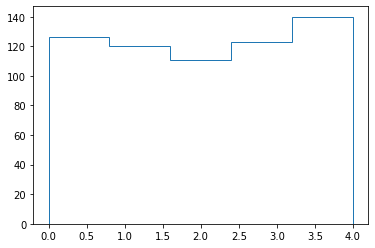

In [5]:
import matplotlib.pyplot as plt

plt.hist(age_class, bins=5, histtype='step')
plt.show()

In [6]:
# Convert to torch

import torch

p_nback_t = torch.from_numpy(p_nback).reshape(-1,264*264).float().cuda()
p_emoid_t = torch.from_numpy(p_emoid).reshape(-1,264*264).float().cuda()
sexes_t = torch.from_numpy(sexes).cuda()
ages_t = torch.from_numpy(ages).float().cuda()

feat_t = torch.cat([p_nback_t, p_emoid_t], dim=1)

print(feat_t.shape)
print('Complete')

torch.Size([620, 139392])
Complete


In [7]:
# Train the model

import torch.nn as nn
import torch.nn.functional as F
# from torch_geometric.nn.conv import DenseGINConv

# ageCls = 4
outputDir = 'PredictAge5AgeCategories/FullTrain'
# outputDir = f'ClassifySex5AgeCategories/AgeGroup{ageCls}'
# outputDir = f'ClassifySex5AgeCategories/FullTrain'

# nCorrectGCN = np.zeros(10)
nCorrectMLP = np.zeros(10)
nTotal = np.zeros(10)

for split in range(10):
    trainIdcs, testIdcs = getTrainTestIdcs(splits, split, True)
    allIdcs = torch.arange(620).long().cuda()
#     trainIdcsAll, testIdcsAll = getTrainTestIdcs(splits, split, True)
    
#     allIdcs = np.argwhere(age_class == ageCls).flatten()
    
#     idcs = np.intersect1d(allIdcs, trainIdcsAll.detach().cpu().numpy())
#     trainIdcs = torch.from_numpy(idcs).cuda()
    
#     idcs = np.intersect1d(allIdcs, testIdcsAll.detach().cpu().numpy())
#     testIdcs = torch.from_numpy(idcs).cuda()
    
#     idcs = np.argwhere(np.isin(allIdcs, idcs)).flatten()
#     testIdcsReindexed = torch.from_numpy(idcs).cuda()
    
#     allIdcs = torch.from_numpy(allIdcs).cuda()

    def normalize(A):
        if A.shape[0] != A.shape[1]:
            raise Exception("Bad A shape")
        d = torch.sum(A,dim=1)**0.5
        return ((A/d).T/d).T

    # Cosine similarity
    def calcEdges(ps1, ps2):
        nB = ps1.shape[0]
        e = torch.einsum('ai,bi->ab',ps1,ps2)
        F1 = torch.einsum('ai,ai->a',ps1,ps1)**0.5
        F2 = torch.einsum('ai,ai->a',ps2,ps2)**0.5
        e /= F1.unsqueeze(1)
        e /= F2.unsqueeze(1).T
    #     e = torch.einsum('aij,bij->ab',ps1,ps2)
    #     F1 = torch.einsum('aij,aij->a',ps1,ps1)**0.5
    #     F2 = torch.einsum('aij,aij->a',ps2,ps2)**0.5
    #     e /= F1.unsqueeze(1)
    #     e /= F2.unsqueeze(1).T
        return normalize(e-torch.eye(nB).float().cuda())

#     Atrain = calcEdges(feat_t[trainIdcs], feat_t[trainIdcs])
#     A = calcEdges(feat_t[allIdcs], feat_t[allIdcs])

#     print(Atrain.shape)
#     print(A.shape)

#     class GCN(nn.Module):
#         def __init__(self):
#             super(GCN, self).__init__()
# #             self.gc1 = DenseGINConv(2*264*264,100).float().cuda()
# #             self.gc2 = DenseGINConv(100,2).float().cuda()
#             self.c = nn.Parameter(torch.ones([2]).float().cuda())
#             self.gc1 = nn.Linear(2*264*264,100).float().cuda()
#             self.gc2 = nn.Linear(100,1).float().cuda()
# #             self.loss = nn.CrossEntropyLoss()
#             self.loss = nn.MSELoss()

#         def forward(self, x):
#             A = x[0]
#             z = x[1]
# #             a = F.relu(self.gc1(z,A))
# #             a = self.gc2(a,A)
# #             return a
#             A0 = A+(self.c[0])*torch.eye(A.shape[0]).float().cuda()
#             A1 = A+(self.c[1])*torch.eye(A.shape[0]).float().cuda()
#             a = A0@z
#             a = F.relu(self.gc1(a))
#             a = A1@a
#             a = self.gc2(a)
#             return a

#     gcn = GCN()
#     optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2) # 1e-5 and 0.2

#     nEpoch = 2000 # 2000 for age pred, 3000 for sex classification, 2000 sex classification GIN
#     pPrint = 200

    sexes_t_train = sexes_t[trainIdcs]
    ages_t_train = ages_t[trainIdcs]
    feat_t_train = feat_t[trainIdcs]

#     for epoch in range(nEpoch):
#         optim.zero_grad()
#         pred = gcn([Atrain,feat_t_train]).flatten()
#         loss = gcn.loss(pred, ages_t_train)
#         loss.backward()
#         optim.step()
#         if epoch % pPrint == 0 or epoch == nEpoch-1:
#             print(f'epoch {epoch} loss={loss}')

#     print(f'Complete GCN {split}')
    
#     torch.save(gcn.state_dict(), f'../../Work/Explainer/Models/{outputDir}/gin{split}.pkl')
    
# #     prob = gcn([A,feat_t[allIdcs]]).squeeze()[testIdcsReindexed].detach().cpu().numpy()
#     prob = gcn([A,feat_t[allIdcs]]).flatten()[testIdcs].detach().cpu().numpy()
#     y = ages_t[testIdcs].detach().cpu().numpy()
# #     y = sexes_t[testIdcs].detach().cpu().numpy()
# #     pred = np.argmax(prob, axis=1)
# #     res = np.sum(pred == y)
#     res = np.mean(np.abs(prob - y))

#     print(f'Correct {res} out of {y.shape[0]}')
    
#     nCorrectGCN[split] = res
    
    class MLP(nn.Module):
        def __init__(self):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(2*264*264,100).float().cuda()
            self.fc2 = nn.Linear(100,1).float().cuda()
#             self.loss = nn.CrossEntropyLoss()
            self.loss = nn.MSELoss()

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    mlp = MLP()
    optim = torch.optim.Adam(mlp.parameters(), lr=1e-5, weight_decay=0.2)

    nEpoch = 1000
    pPrint = 200

    for epoch in range(nEpoch):
        optim.zero_grad()
        pred = mlp(feat_t_train).flatten()
        loss = mlp.loss(pred, ages_t_train)
        loss.backward()
        optim.step()
        if epoch % pPrint == 0 or epoch == nEpoch-1:
            print(f'epoch {epoch} loss={loss}')

    print(f'Complete MLP {split}')
    
    torch.save(mlp.state_dict(), f'../../Work/Explainer/Models/{outputDir}/mlp{split}.pkl')

#     prob = mlp(feat_t[allIdcs]).squeeze()[testIdcsReindexed].detach().cpu().numpy()
#     prob = mlp(feat_t[allIdcs]).squeeze()[testIdcs].detach().cpu().numpy()
#     y = sexes_t[testIdcs].detach().cpu().numpy()
#     pred = np.argmax(prob, axis=1)
#     res = np.sum(pred == y)

#     print(f'Correct {res} out of {y.shape[0]}')
    
    res = mlp(feat_t[allIdcs]).flatten()[testIdcs].detach().cpu().numpy()
    mae = np.mean(np.abs(res-ages_t[testIdcs].detach().cpu().numpy()))
    
    print(f'Average mae {mae} for split {split}')
    
    nCorrectMLP[split] = mae
#     nTotal[split] = y.shape[0]
    
# print(nCorrectGCN)
print(nCorrectMLP)
# print(nTotal)

epoch 0 loss=236.42994689941406
epoch 200 loss=11.659634590148926
epoch 400 loss=4.543851852416992
epoch 600 loss=2.5435009002685547
epoch 800 loss=1.6462658643722534
epoch 999 loss=1.1599195003509521
Complete MLP 0
Average mae 1.8255560398101807 for split 0
epoch 0 loss=234.8246307373047
epoch 200 loss=10.961859703063965
epoch 400 loss=6.151520729064941
epoch 600 loss=3.3125154972076416
epoch 800 loss=1.8903701305389404
epoch 999 loss=1.2804919481277466
Complete MLP 1
Average mae 1.739279866218567 for split 1
epoch 0 loss=236.91416931152344
epoch 200 loss=11.375875473022461
epoch 400 loss=5.039421558380127
epoch 600 loss=3.0113000869750977
epoch 800 loss=2.0516772270202637
epoch 999 loss=1.5045759677886963
Complete MLP 2
Average mae 1.6819977760314941 for split 2
epoch 0 loss=235.35813903808594
epoch 200 loss=9.001641273498535
epoch 400 loss=4.376717567443848
epoch 600 loss=2.4443955421447754
epoch 800 loss=1.5907121896743774
epoch 999 loss=1.0704313516616821
Complete MLP 3
Average ma

In [14]:
np.mean(nCorrectGCN)

1.7623294234275817

In [34]:
np.sum(nCorrectMLP)/np.sum(nTotal)

0.7428571428571429